In [1]:
from sklearn.model_selection import KFold, train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import joypy

from tqdm.notebook import tqdm
from glob import glob
import gc

import nilearn as nl
import nilearn.plotting as nlplt
import nibabel as nib

import h5py

#import lightgbm as lgb

from scipy.stats import skew, kurtosis

import os, random

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.utils import Sequence

In [ ]:
# Need not to download the heavy images files to build the model and train it. Only if you are interested in 
# visualizing brain scanned  images then go for it.

In [3]:
MAIN_DATA_PATH = 'D:/neuro/'

In [11]:
# The first set of features are source-based morphometry (SBM) loadings. These are subject-level weights from 
# a group-level ICA decomposition of gray matter concentration maps from structural MRI (sMRI) scans.

loading_df = pd.read_csv(MAIN_DATA_PATH + 'loading.csv') #loading.csv - sMRI SBM loadings for both train and test samples

print(loading_df.shape)
print(loading_df.shape[0]/2)

(11754, 27)
5877.0


In [12]:
loading_df.head()


Id     IC_01     IC_07     IC_05     IC_16     IC_26     IC_06  \
0  10001  0.006070  0.014466  0.004136  0.000658 -0.002742  0.005033   
1  10002  0.009087  0.009291  0.007049 -0.002076 -0.002227  0.004605   
2  10003  0.008151  0.014684  0.010444 -0.005293 -0.002913  0.015042   
3  10004  0.004675  0.000957  0.006154 -0.000429 -0.001222  0.011755   
4  10005 -0.000398  0.006878  0.009051  0.000369  0.000336  0.010679   

      IC_10     IC_09     IC_18  ...     IC_08     IC_03     IC_21     IC_28  \
0  0.016720  0.003484  0.001797  ...  0.018246  0.023711  0.009177 -0.013929   
1  0.012277  0.002946  0.004086  ...  0.014635  0.022556  0.012004 -0.011814   
2  0.017745  0.003930 -0.008021  ...  0.019565  0.030616  0.018184 -0.010469   
3  0.013010  0.000193  0.008075  ...  0.002658  0.022266  0.005956 -0.010595   
4  0.010352  0.003637  0.004180  ...  0.009702  0.017257  0.005454 -0.008591   

      IC_11     IC_20     IC_30     IC_22     IC_29     IC_14  
0  0.030696  0.010496  0.002892 -0.023235  0.022177  0.017192  
1  0.022479  0.005739  0.002880 -0.016609  0.025543  0.014524  
2  0.029799  0.015435  0.005211 -0.028882  0.031427  0.018164  
3  0.024078 -0.000319  0.005866 -0.015182  0.024476  0.014760  
4  0.019416  0.000786  0.002692 -0.019814  0.017105  0.013316  

[5 rows x 27 columns]

In [17]:
# The second set are static functional network connectivity (FNC) matrices. These are the subject-level cross-correlation 
# values among 53 component timecourses estimated from GIG-ICA of resting state functional MRI (fMRI).

fnc_df = pd.read_csv(MAIN_DATA_PATH + 'fnc.csv')  #fnc.csv - static FNC correlation features for both train and test samples

print(fnc_df.shape)

(11754, 1379)


In [15]:
fnc_df.head()

Id  SCN(53)_vs_SCN(69)  SCN(98)_vs_SCN(69)  SCN(99)_vs_SCN(69)  \
0  10001            0.368580            0.166876            0.438148   
1  10002            0.151696           -0.024819            0.217504   
2  10003            0.343415            0.109974            0.741641   
3  10004            0.132793            0.258255            0.490769   
4  10005            0.291921            0.251254            0.416470   

   SCN(45)_vs_SCN(69)  ADN(21)_vs_SCN(69)  ADN(56)_vs_SCN(69)  \
0            0.341007           -0.186251            0.049096   
1            0.418072           -0.227234           -0.064052   
2            0.578558           -0.676446           -0.436960   
3            0.342717            0.091112            0.107969   
4            0.511719           -0.362626           -0.164710   

   SMN(3)_vs_SCN(69)  SMN(9)_vs_SCN(69)  SMN(2)_vs_SCN(69)  ...  \
0           0.121417          -0.174268          -0.231578  ...   
1          -0.143832          -0.118116          -0.054825  ...   
2          -0.295663          -0.377790          -0.344963  ...   
3           0.029220          -0.026237           0.094742  ...   
4          -0.289059          -0.015537          -0.087316  ...   

   CBN(13)_vs_DMN(94)  CBN(18)_vs_DMN(94)  CBN(4)_vs_DMN(94)  \
0           -0.149279            0.552841           0.131046   
1           -0.214216           -0.039792           0.143014   
2           -0.154941            0.136850          -0.022361   
3           -0.130339            0.309540           0.141469   
4           -0.139525            0.394932           0.040443   

   CBN(7)_vs_DMN(94)  CBN(18)_vs_CBN(13)  CBN(4)_vs_CBN(13)  \
0           0.335446            0.394867          -0.042853   
1          -0.189962            0.498373           0.444231   
2           0.137625            0.677972           0.409412   
3           0.030853            0.344394           0.214097   
4           0.428334            0.498837           0.266755   

   CBN(7)_vs_CBN(13)  CBN(4)_vs_CBN(18)  CBN(7)_vs_CBN(18)  CBN(7)_vs_CBN(4)  
0           0.124627          -0.060712           0.515964          0.290488  
1           0.592438           0.028649           0.705524          0.248327  
2           0.563892           0.438684           0.618204          0.284474  
3           0.317556           0.012435           0.665937          0.081358  
4           0.227379           0.028984           0.752343          0.087898  

[5 rows x 1379 columns]

In [19]:
# The third set of features are the component spatial maps (SM). These are the subject-level 3D images of 53 spatial networks 
# estimated from GIG-ICA of resting state functional MRI (fMRI).

icn_numbers_df = pd.read_csv(MAIN_DATA_PATH + 'ICN_numbers.csv')

# ICN_numbers.csv - intrinsic connectivity network numbers for each fMRI spatial map; matches FNC names

print(icn_numbers_df.shape)



(53, 1)


In [55]:
icn_numbers_df.head()

ICN_number
0          69
1          53
2          98
3          99
4          45

In [32]:

#train_scores.csv - age and assessment values for train samples

train_scores_df = pd.read_csv(MAIN_DATA_PATH + 'train_scores.csv') 
train_scores_df['is_train_set'] = 'yes'

print(train_scores_df.shape)



(5877, 7)


In [33]:
train_scores_df.head()

Id        age  domain1_var1  domain1_var2  domain2_var1  domain2_var2  \
0  10001  57.436077     30.571975     62.553736     53.325130     51.427998   
1  10002  59.580851     50.969456     67.470628     60.651856     58.311361   
2  10004  71.413018     53.152498     58.012103     52.418389     62.536641   
3  10005  66.532630           NaN           NaN     52.108977     69.993075   
4  10007  38.617381     49.197021     65.674285     40.151376     34.096421   

  is_train_set  
0          yes  
1          yes  
2          yes  
3          yes  
4          yes

Text(0.5, 0.98, 'Target Variables distributions')

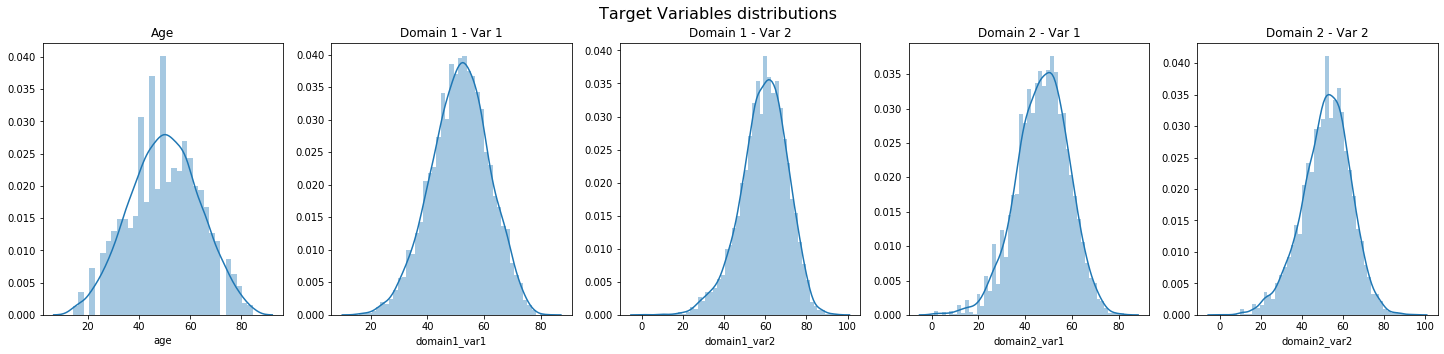

In [24]:
# distribution of the target variables

fig, ax = plt.subplots(1, 5, figsize=(25, 5))

sns.distplot(train_scores_df['age'], ax=ax[0])
ax[0].set_title('Age')

sns.distplot(train_scores_df['domain1_var1'], ax=ax[1])
ax[1].set_title('Domain 1 - Var 1')

sns.distplot(train_scores_df['domain1_var2'], ax=ax[2])
ax[2].set_title('Domain 1 - Var 2')

sns.distplot(train_scores_df['domain2_var1'], ax=ax[3])
ax[3].set_title('Domain 2 - Var 1')

sns.distplot(train_scores_df['domain2_var2'], ax=ax[4])
ax[4].set_title('Domain 2 - Var 2')

fig.suptitle('Target Variables distributions', fontsize=16)

In [26]:
print(train_scores_df.isna().sum())
print(train_scores_df.isna().sum() / len(train_scores_df))

Id                0
age               0
domain1_var1    438
domain1_var2    438
domain2_var1     39
domain2_var2     39
dtype: int64
Id              0.000000
age             0.000000
domain1_var1    0.074528
domain1_var2    0.074528
domain2_var1    0.006636
domain2_var2    0.006636
dtype: float64


In [28]:
train_scores_df.mean()

Id              15909.667007
age                50.034068
domain1_var1       51.474692
domain1_var2       59.244132
domain2_var1       47.325130
domain2_var2       51.905658
dtype: float64

In [29]:
train_scores_df.fillna(train_scores_df.mean(), inplace=True)

In [30]:
train_scores_df.isna().sum()

Id              0
age             0
domain1_var1    0
domain1_var2    0
domain2_var1    0
domain2_var2    0
dtype: int64

In [9]:
loading_df.head()

Id     IC_01     IC_07     IC_05     IC_16     IC_26     IC_06  \
0  10001  0.006070  0.014466  0.004136  0.000658 -0.002742  0.005033   
1  10002  0.009087  0.009291  0.007049 -0.002076 -0.002227  0.004605   
2  10003  0.008151  0.014684  0.010444 -0.005293 -0.002913  0.015042   
3  10004  0.004675  0.000957  0.006154 -0.000429 -0.001222  0.011755   
4  10005 -0.000398  0.006878  0.009051  0.000369  0.000336  0.010679   

      IC_10     IC_09     IC_18  ...     IC_08     IC_03     IC_21     IC_28  \
0  0.016720  0.003484  0.001797  ...  0.018246  0.023711  0.009177 -0.013929   
1  0.012277  0.002946  0.004086  ...  0.014635  0.022556  0.012004 -0.011814   
2  0.017745  0.003930 -0.008021  ...  0.019565  0.030616  0.018184 -0.010469   
3  0.013010  0.000193  0.008075  ...  0.002658  0.022266  0.005956 -0.010595   
4  0.010352  0.003637  0.004180  ...  0.009702  0.017257  0.005454 -0.008591   

      IC_11     IC_20     IC_30     IC_22     IC_29     IC_14  
0  0.030696  0.010496  0.002892 -0.023235  0.022177  0.017192  
1  0.022479  0.005739  0.002880 -0.016609  0.025543  0.014524  
2  0.029799  0.015435  0.005211 -0.028882  0.031427  0.018164  
3  0.024078 -0.000319  0.005866 -0.015182  0.024476  0.014760  
4  0.019416  0.000786  0.002692 -0.019814  0.017105  0.013316  

[5 rows x 27 columns]

<Figure size 2000x1200 with 0 Axes>

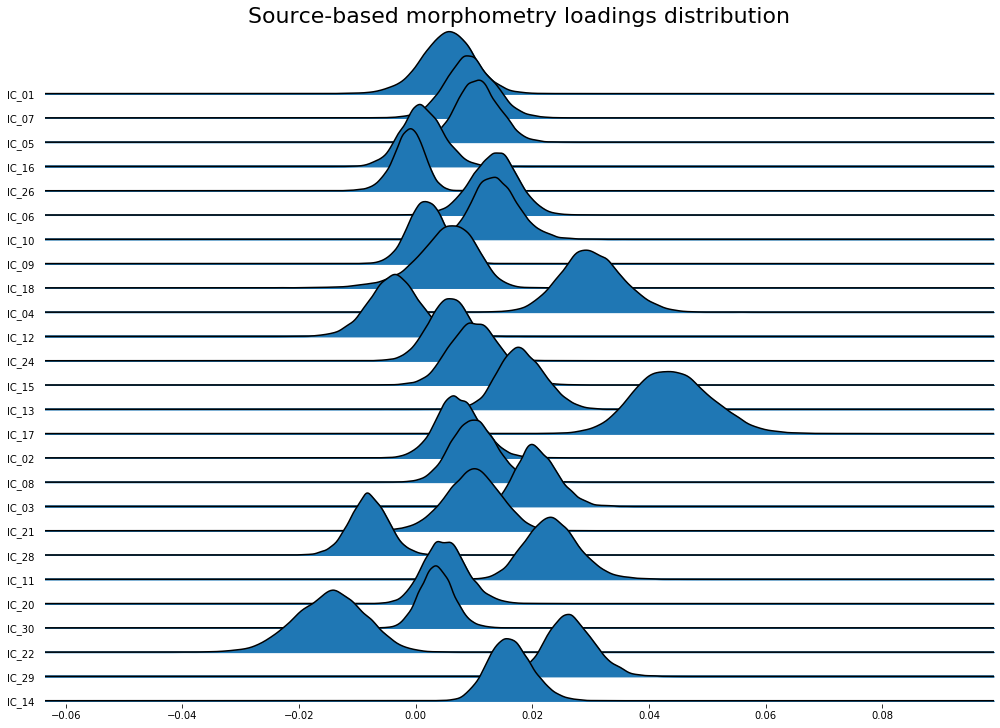

In [31]:
targets = loading_df.columns[1:]

plt.figure(figsize=(20,12), dpi= 100)
fig, axes = joypy.joyplot(loading_df, column=list(targets), ylim='own', figsize=(14,10))

# Decoration
plt.title('Source-based morphometry loadings distribution', fontsize=22)
plt.show()

In [45]:
features_df = pd.merge(train_scores_df, loading_df, on=['Id'], how='left')
features_df.is_train_set = features_df.is_train_set.fillna('no')
features_df.head()


Id        age  domain1_var1  domain1_var2  domain2_var1  domain2_var2  \
0  10001  57.436077     30.571975     62.553736     53.325130     51.427998   
1  10002  59.580851     50.969456     67.470628     60.651856     58.311361   
2  10004  71.413018     53.152498     58.012103     52.418389     62.536641   
3  10005  66.532630           NaN           NaN     52.108977     69.993075   
4  10007  38.617381     49.197021     65.674285     40.151376     34.096421   

  is_train_set     IC_01     IC_07     IC_05  ...     IC_08     IC_03  \
0          yes  0.006070  0.014466  0.004136  ...  0.018246  0.023711   
1          yes  0.009087  0.009291  0.007049  ...  0.014635  0.022556   
2          yes  0.004675  0.000957  0.006154  ...  0.002658  0.022266   
3          yes -0.000398  0.006878  0.009051  ...  0.009702  0.017257   
4          yes  0.005192  0.010585  0.012160  ...  0.006218  0.017332   

      IC_21     IC_28     IC_11     IC_20     IC_30     IC_22     IC_29  \
0  0.009177 -0.013929  0.030696  0.010496  0.002892 -0.023235  0.022177   
1  0.012004 -0.011814  0.022479  0.005739  0.002880 -0.016609  0.025543   
2  0.005956 -0.010595  0.024078 -0.000319  0.005866 -0.015182  0.024476   
3  0.005454 -0.008591  0.019416  0.000786  0.002692 -0.019814  0.017105   
4  0.016791 -0.009594  0.019757  0.003731  0.000733 -0.008462  0.026733   

      IC_14  
0  0.017192  
1  0.014524  
2  0.014760  
3  0.013316  
4  0.014358  

[5 rows x 33 columns]

In [46]:
features_df.shape

(5877, 33)

In [47]:
features_df.is_train_set.value_counts(dropna =False)

yes    5877
Name: is_train_set, dtype: int64

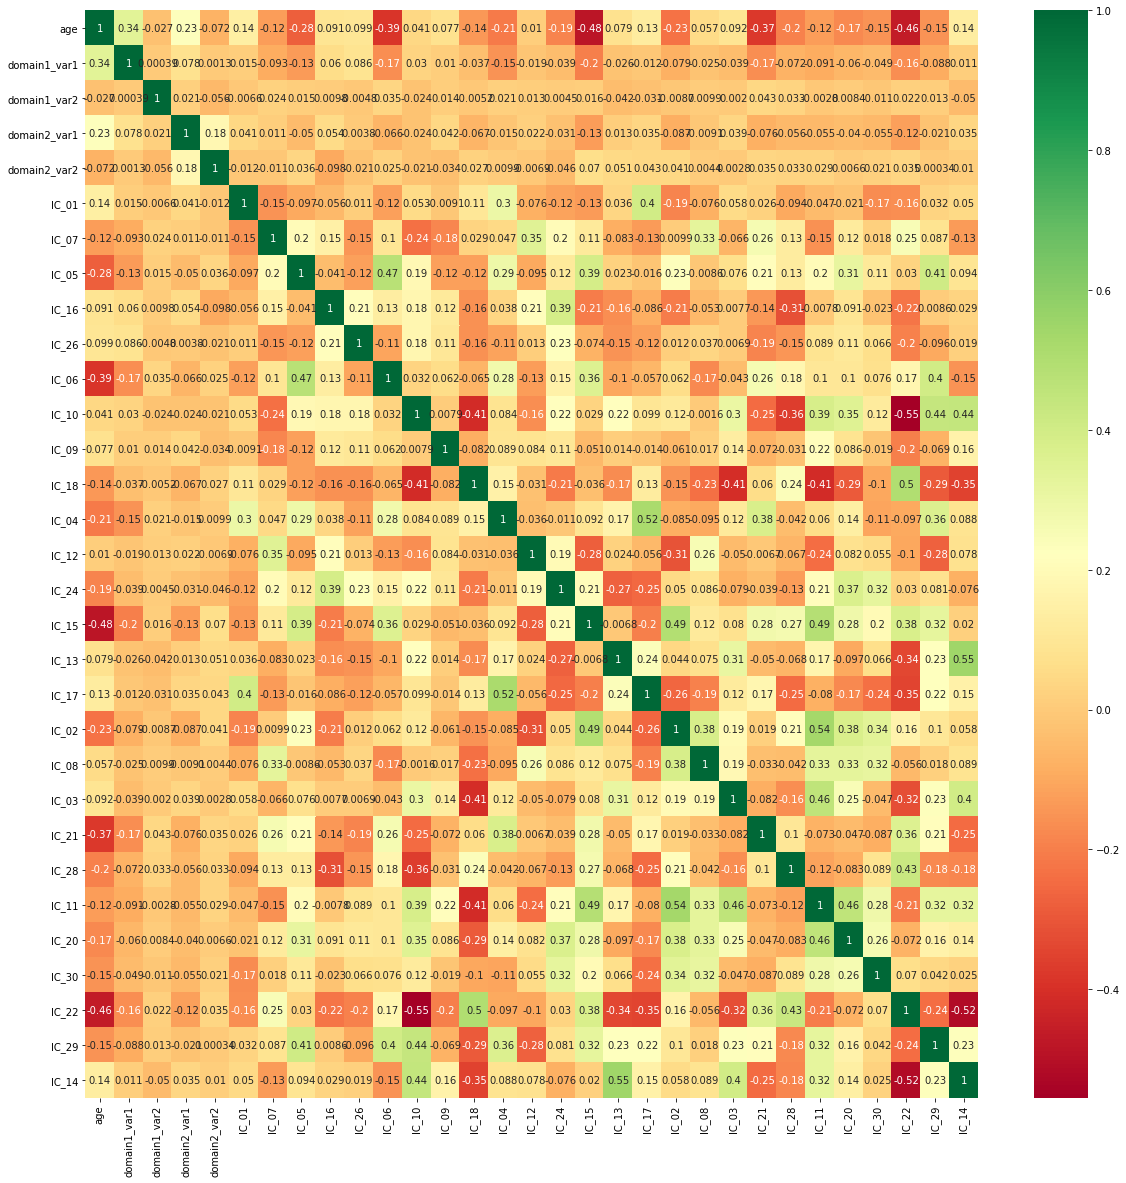

In [48]:
fig, ax = plt.subplots(figsize=(20, 20))
cols = features_df.columns[1:]
sns.heatmap(features_df[cols].corr(), annot=True, cmap='RdYlGn', ax=ax)

In [14]:
fnc_df.isna().sum().sum()

0

In [49]:
features_df = pd.merge(features_df, fnc_df, how='left', on='Id')
features_df.head()

Id        age  domain1_var1  domain1_var2  domain2_var1  domain2_var2  \
0  10001  57.436077     30.571975     62.553736     53.325130     51.427998   
1  10002  59.580851     50.969456     67.470628     60.651856     58.311361   
2  10004  71.413018     53.152498     58.012103     52.418389     62.536641   
3  10005  66.532630           NaN           NaN     52.108977     69.993075   
4  10007  38.617381     49.197021     65.674285     40.151376     34.096421   

  is_train_set     IC_01     IC_07     IC_05  ...  CBN(13)_vs_DMN(94)  \
0          yes  0.006070  0.014466  0.004136  ...           -0.149279   
1          yes  0.009087  0.009291  0.007049  ...           -0.214216   
2          yes  0.004675  0.000957  0.006154  ...           -0.130339   
3          yes -0.000398  0.006878  0.009051  ...           -0.139525   
4          yes  0.005192  0.010585  0.012160  ...           -0.150218   

   CBN(18)_vs_DMN(94)  CBN(4)_vs_DMN(94)  CBN(7)_vs_DMN(94)  \
0            0.552841           0.131046           0.335446   
1           -0.039792           0.143014          -0.189962   
2            0.309540           0.141469           0.030853   
3            0.394932           0.040443           0.428334   
4            0.408926           0.072004           0.157582   

   CBN(18)_vs_CBN(13)  CBN(4)_vs_CBN(13)  CBN(7)_vs_CBN(13)  \
0            0.394867          -0.042853           0.124627   
1            0.498373           0.444231           0.592438   
2            0.344394           0.214097           0.317556   
3            0.498837           0.266755           0.227379   
4            0.532046           0.355448           0.462675   

   CBN(4)_vs_CBN(18)  CBN(7)_vs_CBN(18)  CBN(7)_vs_CBN(4)  
0          -0.060712           0.515964          0.290488  
1           0.028649           0.705524          0.248327  
2           0.012435           0.665937          0.081358  
3           0.028984           0.752343          0.087898  
4           0.161005           0.703679          0.293607  

[5 rows x 1411 columns]

In [50]:
features_df.shape

(5877, 1411)

In [56]:
fnc_features, loading_features = list(fnc_df.columns[1:]), list(loading_df.columns[1:])

In [70]:
X = fnc_df.merge(loading_df, on="Id")

In [76]:
test_df = X[X["is_train_set"] != 'yes']

KeyError: 'is_train_set'

In [72]:
train_scores_df.head()

Id        age  domain1_var1  domain1_var2  domain2_var1  domain2_var2  \
0  10001  57.436077     30.571975     62.553736     53.325130     51.427998   
1  10002  59.580851     50.969456     67.470628     60.651856     58.311361   
2  10004  71.413018     53.152498     58.012103     52.418389     62.536641   
3  10005  66.532630           NaN           NaN     52.108977     69.993075   
4  10007  38.617381     49.197021     65.674285     40.151376     34.096421   

  is_train_set  
0          yes  
1          yes  
2          yes  
3          yes  
4          yes

In [17]:
mask_filename = 'D:/neuro/fMRI_mask.nii'
mask_niimg = nl.image.load_img(mask_filename)

In [24]:
subject_filename = 'D:/neuro/10004.mat'

In [25]:
subject_filename

'D:/neuro/10004.mat'

In [26]:
smri_filename = 'D:/neuro/ch2better.nii'

In [27]:
# Credits to https://www.kaggle.com/soham1024/visualization-using-nilearn/notebook

In [28]:
def load_subject(filename, mask_niimg):
    """
    Load a subject saved in .mat format with
        the version 7.3 flag. Return the subject
        niimg, using a mask niimg as a template
        for nifti headers.
        
    Args:
        filename    <str>            the .mat filename for the subject data
        mask_niimg  niimg object     the mask niimg object used for nifti headers
    """
    subject_data = None
    with h5py.File(subject_filename, 'r') as f:
        subject_data = f['SM_feature'][()]
    # It's necessary to reorient the axes, since h5py flips axis order
    subject_data = np.moveaxis(subject_data, [0,1,2,3], [3,2,1,0])
    subject_niimg = nl.image.new_img_like(mask_niimg, subject_data, affine=mask_niimg.affine, copy_header=True)
    return subject_niimg

In [30]:
subject_niimg = load_subject(subject_filename, mask_niimg)


In [31]:
print("Image shape is %s" % (str(subject_niimg.shape)))
num_components = subject_niimg.shape[-1]
print("Detected {num_components} spatial maps".format(num_components=num_components))

Image shape is (53, 63, 52, 53)
Detected 53 spatial maps


C:\Users\Vignesh\anaconda3\lib\site-packages\nilearn\plotting\displays.py:99: UserWarning: linewidths is ignored by contourf
  **kwargs)
C:\Users\Vignesh\anaconda3\lib\site-packages\nilearn\plotting\displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)


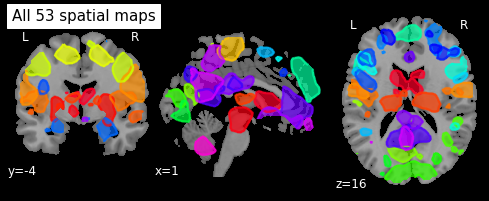

In [32]:
nlplt.plot_prob_atlas(subject_niimg, bg_img=smri_filename, view_type='filled_contours', 
                      draw_cross=False, title='All %d spatial maps' % num_components, threshold='auto')

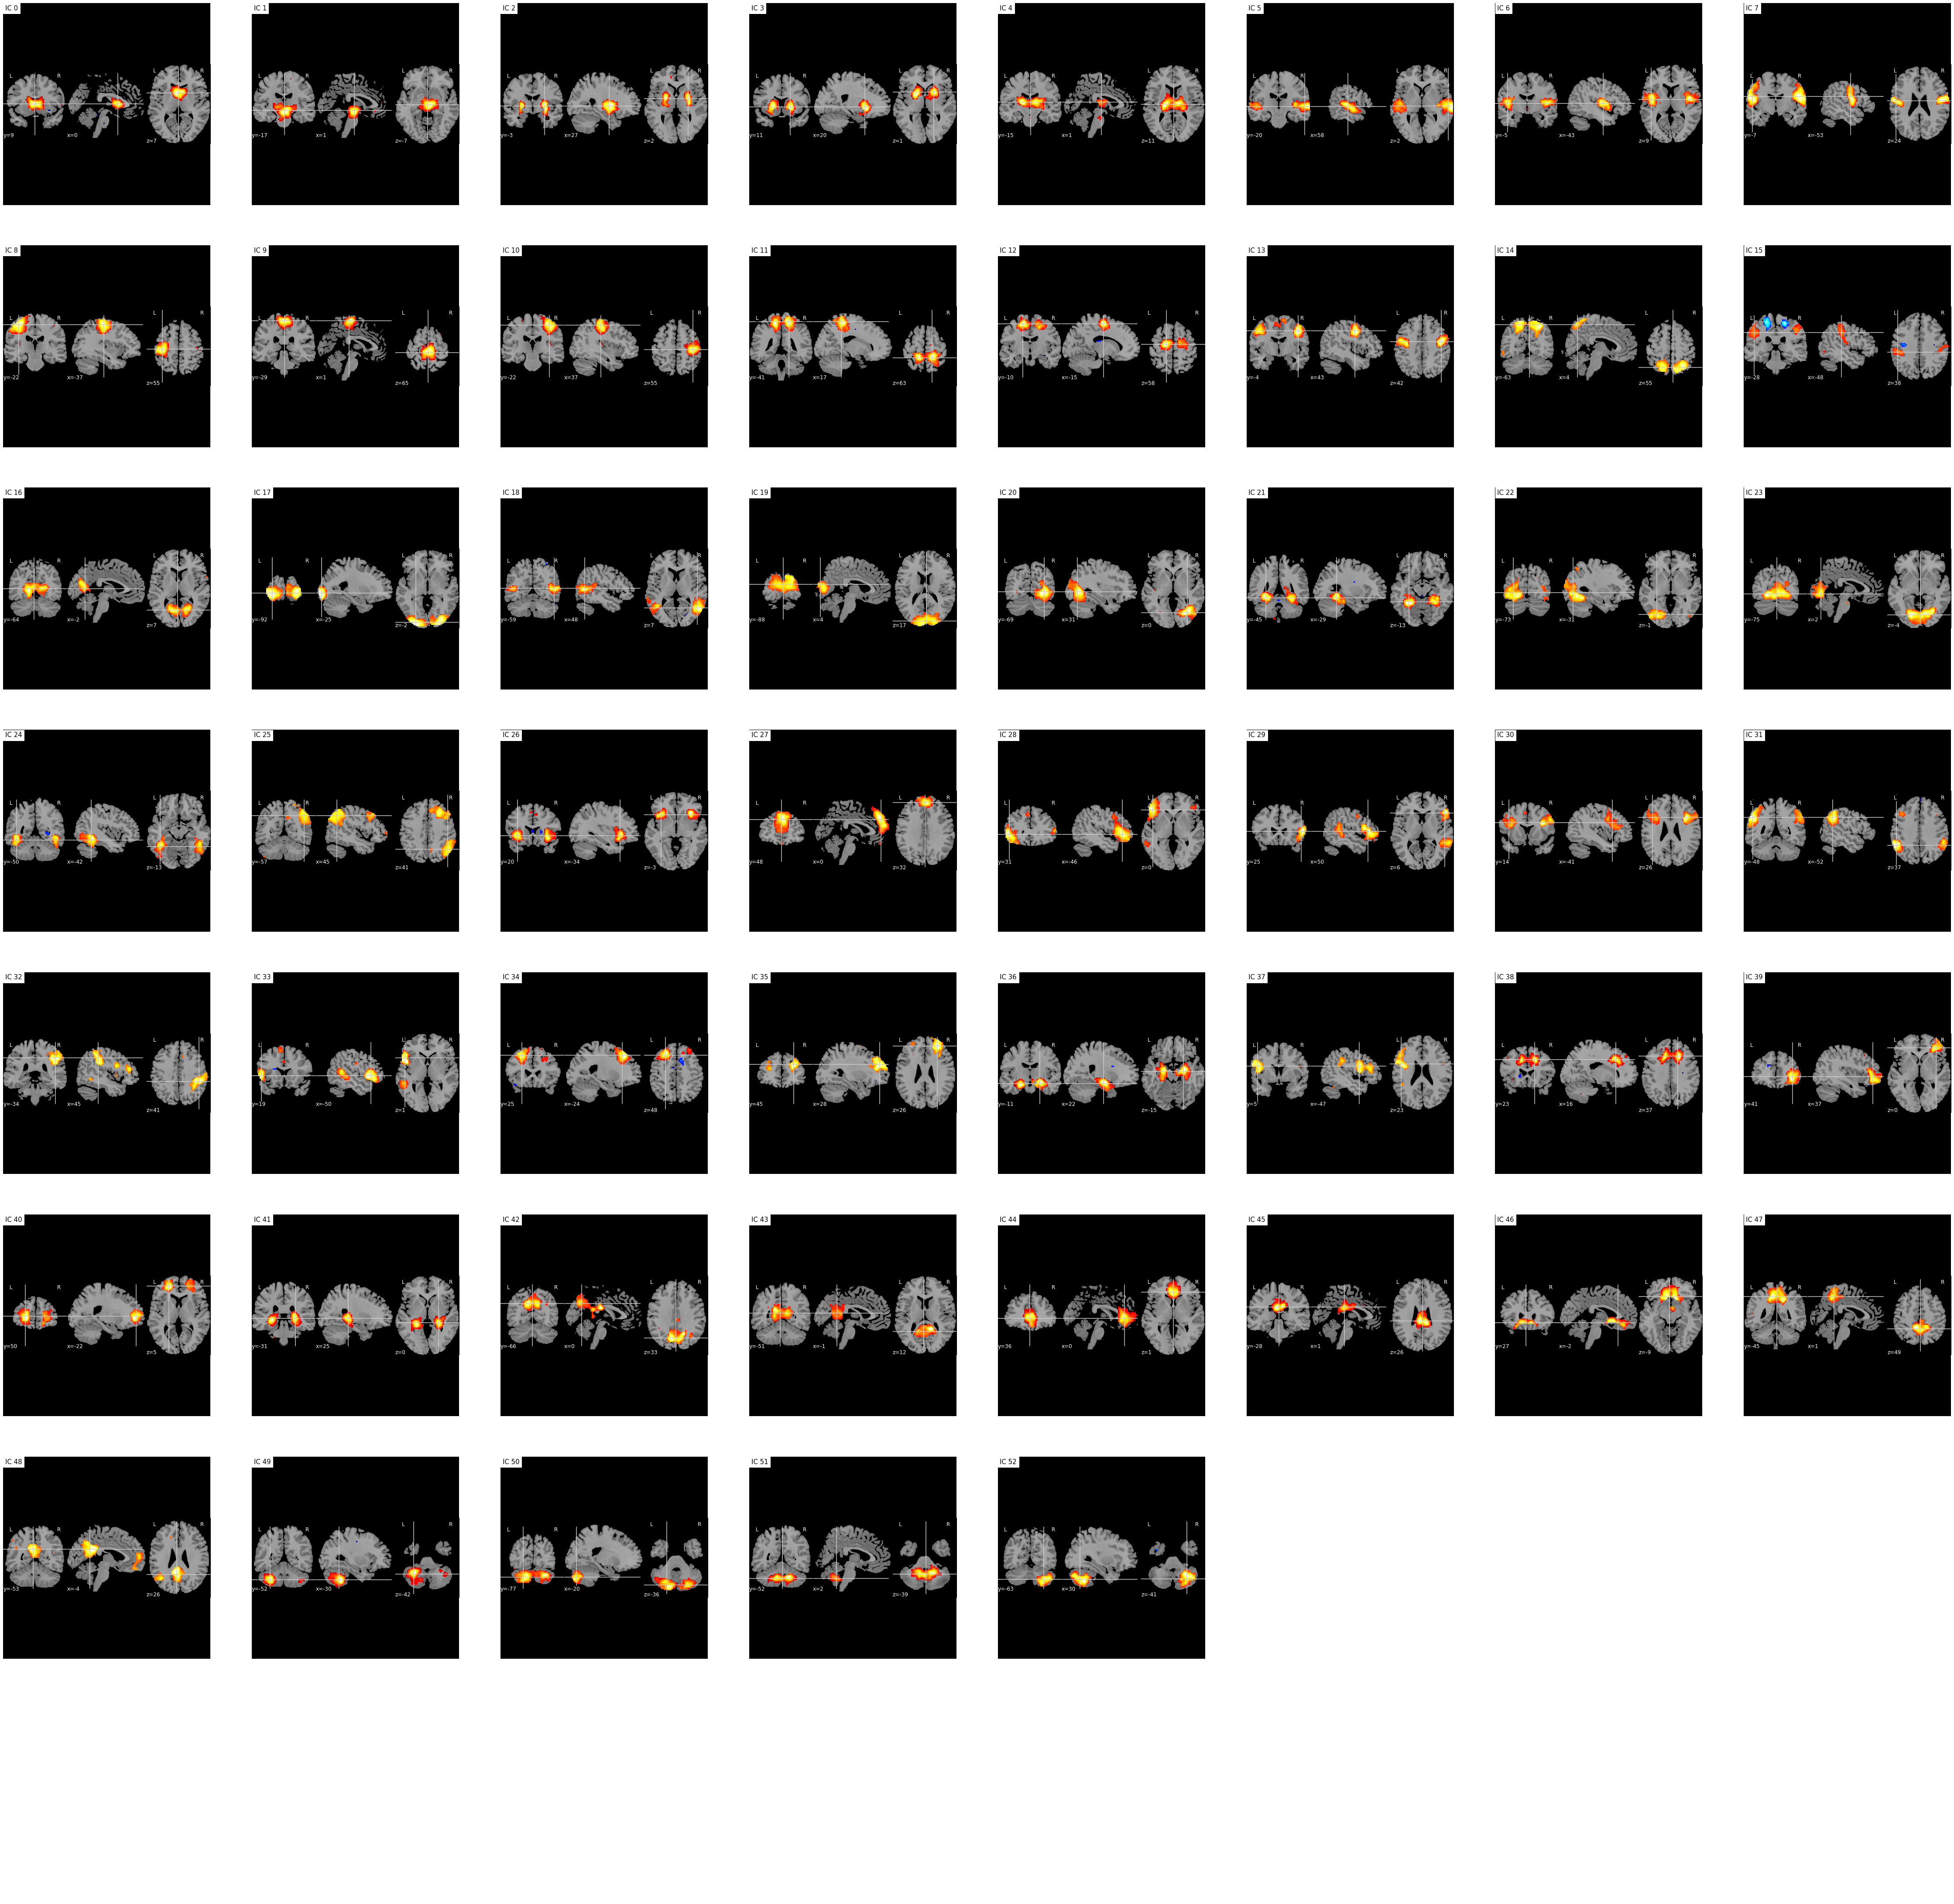

In [33]:
grid_size = int(np.ceil(np.sqrt(num_components)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size*10, grid_size*10))
[axi.set_axis_off() for axi in axes.ravel()]
row = -1
for i, cur_img in enumerate(nl.image.iter_img(subject_niimg)):
    col = i % grid_size
    if col == 0:
        row += 1
    nlplt.plot_stat_map(cur_img, bg_img=smri_filename, title="IC %d" % i, axes=axes[row, col], threshold=3, colorbar=False)

In [34]:
subject_niimg

In [35]:
subject_niimg.shape

(53, 63, 52, 53)

In [43]:
print(subject_niimg.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 4 53 63 52 53  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  3.  3.  3.  0.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 11.527723
cal_min         : -8.082875
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'Warped - conv(6,6,6)'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 78.0
qoffset_y       : -112.0
qoffset_z       : -70.0
srow_x         

In [44]:
subject_niimg.affine

array([[  -3.,    0.,    0.,   78.],
       [   0.,    3.,    0., -112.],
       [   0.,    0.,    3.,  -70.],
       [   0.,    0.,    0.,    1.]])